In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis'
figdir_supp = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp'
misc.get_or_create_subdir(figdir)
misc.get_or_create_subdir(figdir_supp)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)

'/mnt/home/szheng/ceph/place_variability/data/paper'

In [5]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [10]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [7]:
best_n_all_ = best_n_all_test
import glob
cell_metrics_df_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    
    cell_metrics=glob.glob(os.path.join(data_dir_full,'*cell_metrics.cellinfo.mat'))[0]
    cell_metrics = dpn.loadmat_full(cell_metrics,'cell_metrics')
    
    metrics=['UID','putativeCellType','firingRate','firingRateCV','firingRate_NREMstate','firingRate_REMstate','firingRate_WAKEstate','burstIndex_Mizuseki2012']
    cell_metrics_df = pd.DataFrame({k:cell_metrics[k] for k in metrics})
    cell_metrics_df_all[ani,sess] = cell_metrics_df
cell_metrics_df_all = pd.concat(cell_metrics_df_all,axis=0)

cell_metrics_df_all['UID'] = cell_metrics_df_all['UID'].astype(int)
cell_metrics_df_all = cell_metrics_df_all.reset_index(level=2,drop=True).set_index('UID',append=True)

# field with any switch vs no switch, metrics
task_index=0
cell_with_any_sw_one_task = best_n_all_.loc[(slice(None),slice(None),task_index)].groupby(level=(0,1,3)).apply(lambda x:(x>0).any())
cell_metrics_df_all['has_switch']  = cell_with_any_sw_one_task

ma=cell_metrics_df_all['has_switch'].notna()
cell_metrics_df_all_pc = cell_metrics_df_all.loc[ma]

In [6]:
import switch_detection_sweep_penalty_one_session as sdspos
pen=0.5#0.3#0.3#0.5

best_n_all = {}
X_pwc_all={}
X_raw_all={}
changes_df_all={}
var_res_all={}
corr_all = {}
p_corr_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    sw_res_pelt = sw_res_pelt[pen]
    
    best_n_all[ani,sess]=sw_res_pelt['best_n']
    X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
    X_raw_all[ani,sess]=sw_res_pelt['X_raw']
    changes_df_all[ani,sess]=sw_res_pelt['changes_df']
    var_res_all[ani,sess]=sw_res_pelt['var_res']
    corr_all[ani,sess]=sw_res_pelt['corr']
    p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
best_n_all = pd.concat(best_n_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/penalty_sw

In [9]:
import variability_axis as va
reload(va)

<module 'variability_axis' from '/mnt/home/szheng/projects/place_variability/code/variability_axis.py'>

### here choose var_res_all (pen) or var_res_all_test (shuffle test)

In [11]:
# per_field_var_metrics=va.get_per_field_var_metrics(X_raw_all,pf_params_recombined_all,all_fields_recombined_all,var_res_all=var_res_all,level=(0,1,2,3),pf_params_loc_ind=2)
per_field_var_metrics=va.get_per_field_var_metrics(X_raw_all,pf_params_recombined_all,all_fields_recombined_all,var_res_all=var_res_all_test,level=(0,1,2,3),pf_params_loc_ind=2)





In [12]:
# per_field_var_metrics=va.get_per_field_var_metrics(X_raw_all,pf_params_recombined_all,all_fields_recombined_all,var_res_all=var_res_all_test,level=(0,1,2,3),pf_params_loc_ind=2)


per_tt_neuron_metrics = va.get_per_neuron_metrics(spk_beh_df_all,fr_map_trial_df_all,fr_map_all,occu_map_all,stab_level=(0,1,2,3,4),si_level=(0,1))


# per_field_metrics_all = va.assign_per_neuron_property_to_field(per_field_var_metrics,per_tt_neuron_metrics)


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may i

/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  cell_cols = fr_map_trial_df_all.loc[k,:].index.get_level_values(2).unique()
/mnt/home/szheng/projects/place_variability/code/variability_axis.py:41: PerformanceWarning: indexing past l

In [15]:
var_res_all_test

tot_var       mean    fit_var  \
e13_26m1 e13_26m1_210913 0 0.0  3  0   4.291338   2.979778   2.108064   
                                27 0  54.997992  33.067719   0.000000   
                                29 0  17.511026   6.059328  10.935146   
                                   1  27.155813  26.288630   0.000000   
                                   2  44.745505  17.481232   0.000000   
...                                         ...        ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0  13.526576   8.682727   0.000000   
                                32 0  35.811976  11.835044   0.000000   
                                38 0  42.932386   9.374712   0.000000   
                                47 0  14.870425   6.453665   0.000000   
                                53 0   7.496653   3.517027   0.000000   

                                      resid2_mean  fit_var_ratio  \
e13_26m1 e13_26m1_210913 0 0.0  3  0     2.183274       0.491237   
                                27 0    54.997992       0.000000   
                                29 0     6.575879       0.624472   
                                   1    27.155813       0.000000   
                                   2    44.745505       0.000000   
...                                           ...            ...   
e14_2m3  e14_2m3_201118  0 both 30 0    13.526576       0.000000   
                                32 0    35.811976       0.000000   
                                38 0    42.932386       0.000000   
                                47 0    14.870425       0.000000   
                                53 0     7.496653       0.000000   

                                      resid2_mean_ratio  tot_var_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.508763      1.440154   
                                27 0           1.000000      1.663193   
                                29 0           0.375528      2.889929   
                                   1           1.000000      1.032987   
                                   2           1.000000      2.559631   
...                                                 ...           ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000      1.557872   
                                32 0           1.000000      3.025927   
                                38 0           1.000000      4.579595   
                                47 0           1.000000      2.304183   
                                53 0           1.000000      2.131531   

                                      fit_var_norm  resid2_mean_norm  
e13_26m1 e13_26m1_210913 0 0.0  3  0      0.707457          0.732697  
                                27 0      0.000000          1.663193  
                                29 0      1.804680          1.085249  
                                   1      0.000000          1.032987  
                                   2      0.000000          2.559631  
...                                            ...               ...  
e14_2m3  e14_2m3_201118  0 both 30 0      0.000000          1.557872  
                                32 0      0.000000          3.025927  
                                38 0      0.000000          4.579595  
                                47 0      0.000000          2.304183  
                                53 0      0.000000          2.131531  

[14438 rows x 9 columns]

In [14]:
per_field_metrics_all

frac_trial_active  fr_cv_beh   loc_std  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.696970   0.705983  4.374080   
                                27 0           1.000000   0.227746  6.913563   
                                29 0           0.787879   0.701315  1.986221   
                                   1           1.000000   0.201301  3.270333   
                                   2           1.000000   0.388584  2.973685   
...                                                 ...        ...       ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000   0.432693  3.326442   
                                32 0           0.958333   0.516519  6.448795   
                                38 0           0.833333   0.713964  1.966661   
                                47 0           0.958333   0.610375  2.738613   
                                53 0           0.708333   0.795243  2.527745   

                                     field_width    tot_var       mean  \
e13_26m1 e13_26m1_210913 0 0.0  3  0          16   4.291338   2.979778   
                                27 0          30  54.997992  33.067719   
                                29 0           7  17.511026   6.059328   
                                   1          18  27.155813  26.288630   
                                   2          16  44.745505  17.481232   
...                                          ...        ...        ...   
e14_2m3  e14_2m3_201118  0 both 30 0          17  13.526576   8.682727   
                                32 0          21  35.811976  11.835044   
                                38 0           7  42.932386   9.374712   
                                47 0           6  14.870425   6.453665   
                                53 0           6   7.496653   3.517027   

                                        fit_var  resid2_mean  fit_var_ratio  \
e13_26m1 e13_26m1_210913 0 0.0  3  0   2.108064     2.183274       0.491237   
                                27 0   0.000000    54.997992       0.000000   
                                29 0  10.935146     6.575879       0.624472   
                                   1   0.000000    27.155813       0.000000   
                                   2   0.000000    44.745505       0.000000   
...                                         ...          ...            ...   
e14_2m3  e14_2m3_201118  0 both 30 0   0.000000    13.526576       0.000000   
                                32 0   0.000000    35.811976       0.000000   
                                38 0   0.000000    42.932386       0.000000   
                                47 0   0.000000    14.870425       0.000000   
                                53 0   0.000000     7.496653       0.000000   

                                      resid2_mean_ratio  tot_var_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0           0.508763      1.440154   
                                27 0           1.000000      1.663193   
                                29 0           0.375528      2.889929   
                                   1           1.000000      1.032987   
                                   2           1.000000      2.559631   
...                                                 ...           ...   
e14_2m3  e14_2m3_201118  0 both 30 0           1.000000      1.557872   
                                32 0           1.000000      3.025927   
                                38 0           1.000000      4.579595   
                                47 0           1.000000      2.304183   
                                53 0           1.000000      2.131531   

                                      fit_var_norm  resid2_mean_norm  \
e13_26m1 e13_26m1_210913 0 0.0  3  0      0.707457          0.732697   
                                27 0      0.000000          1.663193   
                                29 0      1.804680          1.085249   
                                   1      0.000000          1.032987   
  

In [13]:
per_field_metrics_all = va.assign_per_neuron_property_to_field(per_field_var_metrics,per_tt_neuron_metrics)

In [64]:
per_field_metrics_all['fit_var_ratio_pen']=var_res_all['fit_var_ratio']

In [66]:
savefn_full = os.path.join(data_dir,'per_field_metrics_all_shtest.p')
pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))

In [105]:
per_field_metrics_all.columns

Index(['frac_trial_active', 'fr_cv_beh', 'soft_frac_trial_active', 'loc_std',
       'field_width', 'tot_var', 'mean', 'fit_var', 'resid2_mean',
       'fit_var_ratio', 'resid2_mean_ratio', 'tot_var_norm', 'fit_var_norm',
       'resid2_mean_norm', 'log_mean', 'lap_correlation', 'si', 'sparsity'],
      dtype='object')

In [67]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler,QuantileTransformer
# feat_cols = ['frac_trial_active','fr_cv_beh','fit_var_ratio','resid2_mean_norm','sparsity']
# feat_cols = ['si','fit_var_ratio','frac_trial_active']
feat_cols = ['si','fit_var_ratio','fit_var_ratio_pen','fr_cv_beh']

# sess = 'e15_13f1_220117'
# per_field_metrics_all_sub = per_field_metrics_all.loc[(slice(None),sess),:]
per_field_metrics_all_sub = per_field_metrics_all.loc[(slice(None),slice(None),[0])]
data=per_field_metrics_all_sub.loc[:,feat_cols]
# data_norm=StandardScaler().fit_transform(data)
data_norm = QuantileTransformer().fit_transform(data)
data_norm = pd.DataFrame(data_norm,index=data.index,columns=data.columns)


In [502]:
import itertools
val_interval_categories={'low':(0,0.2),'mid':(0.4,0.6),'high':(0.8,1.)}

n_feat_cols = len(feat_cols)
category_combo_l = list(itertools.product(val_interval_categories,repeat=n_feat_cols))
ma_l = {}
for catco in category_combo_l:
    ma = np.ones(data_norm.shape[0],dtype=bool)
    ma_name = []
    for ii,cat in enumerate(catco):
        val_interval = val_interval_categories[cat]
        feat = feat_cols[ii]
        ma&=(data_norm[feat]>=val_interval[0])&(data_norm[feat]<=val_interval[1])
        ma_name.append(f'{feat}_{cat}')
    ma_name = '; '.join(ma_name)
    ma_l[ma_name]=ma
ma_l = pd.concat(ma_l,axis=1)
        


In [487]:
ma_l.sum(axis=0)

si_low; fit_var_ratio_low; frac_trial_active_low       125
si_low; fit_var_ratio_low; frac_trial_active_mid       236
si_low; fit_var_ratio_low; frac_trial_active_high      644
si_low; fit_var_ratio_mid; frac_trial_active_low        55
si_low; fit_var_ratio_mid; frac_trial_active_mid        59
si_low; fit_var_ratio_mid; frac_trial_active_high       38
si_low; fit_var_ratio_high; frac_trial_active_low       34
si_low; fit_var_ratio_high; frac_trial_active_mid       81
si_low; fit_var_ratio_high; frac_trial_active_high     170
si_mid; fit_var_ratio_low; frac_trial_active_low       248
si_mid; fit_var_ratio_low; frac_trial_active_mid       210
si_mid; fit_var_ratio_low; frac_trial_active_high      448
si_mid; fit_var_ratio_mid; frac_trial_active_low       140
si_mid; fit_var_ratio_mid; frac_trial_active_mid        70
si_mid; fit_var_ratio_mid; frac_trial_active_high       32
si_mid; fit_var_ratio_high; frac_trial_active_low       83
si_mid; fit_var_ratio_high; frac_trial_active_mid      1

In [488]:
reload(va)
data_norm_tsp,tsp_inds=va.tsp_from_data(data_norm)
data_tsp = data.iloc[tsp_inds]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_59910/3794580359.py", line 2, in <cell line: 2>
    data_norm_tsp,tsp_inds=va.tsp_from_data(data_norm)
  File "/mnt/home/szheng/projects/place_variability/code/variability_axis.py", line 123, in tsp_from_data
    tsp_inds,_=tsp.solve_tsp(data_dist)
  File "/mnt/home/szheng/projects/nmf_analysis/tsp.py", line 75, in solve_tsp
    idx = np.argsort(path)
  File "<__array_function__ internals>", line 5, in argsort
  File "/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 1114, in argsort
    return _wrapfunc(a, 'argsort', axis=axis, kind=kind, order=order)
  File "/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 57, in _wrapfunc
    return bound(*args, **kwds)
KeyboardInter

In [469]:
# figdir_supp_pen=misc.get_or_create_subdir(figdir_supp,f'ex_pen_{pen:.0e}')
figdir_supp_pen=misc.get_or_create_subdir(figdir_supp,f'ex_shtest')

/mnt/home/szheng/ceph/place_variability/fig/paper/figure_variability_axis/supp/ex_shtest made!


In [470]:
%matplotlib inline
# ma=(data_norm_tsp['sparsity'] <-1.)&(data_norm_tsp['loc_std']>0.5) 
for combo_name,ma in ma_l.T.iterrows():
    data_norm_tsp.loc[ma]
    toplot_inds=data_norm_tsp.loc[ma].index[:12]
    nplots=len(toplot_inds)
    if nplots>4:

        fig,axs=ph.subplots_wrapper(nplots,squeeze=False)

        for ii,jj in enumerate(toplot_inds):
            ani,sess,ti,tt,uid,field_id=jj
            if tt=='both':
                tt_rm=0
            else:
                tt_rm=tt
            field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]

            fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
            ax=axs.ravel()[ii]
            ph.ratemap_one_raw(fr_map_trial_one,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})
            ax.set_title(f'{tt}, {uid}, {field_id}')
        plt.tight_layout()
        fn_full = os.path.join(figdir_supp_pen,f'{combo_name}_examples.png')
        fig.savefig(fn_full,bbox_inches='tight')
        plt.close(fig)

/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipyke

/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipyke

/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipyke

/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipyke

/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/3865701612.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipyke

# plot all points, circle out the selected ones

In [492]:
selected.sample(1).index[0]

('e15_13f1', 'e15_13f1_220117', 0, 1.0, 267, 1)

In [503]:
# select example from each combo of categories of features
import itertools
val_interval_categories={'low':(0,0.2),'mid':(0.4,0.6),'high':(0.8,1.)}
# val_interval_categories={'low':(0.,0.2),'high':(0.8,1.)}

data_to_select_from = data_to_plot = data # the end result to show
data_to_use_for_category = data_norm # for seperating data

n_feat_cols = len(feat_cols)
category_combo_l = list(itertools.product(val_interval_categories,repeat=n_feat_cols))
ma_l = {}

feat_l = []
cat_l = {k:[] for k in feat_l}
selected_l = []



data_selected_with_feat_cat_l = []
feat_cols_cat = [f'{k}_cat' for k in feat_cols]
for catco in category_combo_l:
    ma = np.ones(data_to_use_for_category.shape[0],dtype=bool)
    ma_name = []
    for ii,cat in enumerate(catco):

        val_interval = val_interval_categories[cat]
        feat = feat_cols[ii]
        
        ma&=(data_to_use_for_category[feat]>=val_interval[0])&(data_to_use_for_category[feat]<=val_interval[1])
    selected = ma.loc[ma]    
    if len(selected)>0:
        feat_cat=pd.Series(catco,index=feat_cols_cat)
#         feat_cat['ind'] = selected.index[0] # may change 
        feat_cat['ind'] = selected.sample(1).index[0] # may change 
        data_selected=data_to_select_from.loc[feat_cat['ind']]
        data_selected_with_feat_cat=pd.concat([data_selected,feat_cat])
        data_selected_with_feat_cat_l.append(data_selected_with_feat_cat)

data_selected_with_feat_cat_l = pd.concat(data_selected_with_feat_cat_l,axis=1).T


In [504]:
colors_d={'high':[1.,0,0],'mid':[0,1.,0],'low':[0,0,1.]}
markers_d={'high':'o','mid':'*','low':'>'}
sizes_d={'high':100,'mid':60,'low':20}

# colors_d={'high':[1.,0,0],'low':[0,0,1.]}
# markers_d={'high':'o','low':'>'}
# sizes_d={'high':100,'low':20}

In [505]:
color_col = 'fit_var_ratio_cat'
c_l = np.stack(data_selected_with_feat_cat_l[color_col].apply(lambda x:colors_d[x]).values,axis=0)
marker_col = 'si_cat'#'lap_correlation_cat'
marker_l = data_selected_with_feat_cat_l[marker_col].apply(lambda x:markers_d[x]).values
size_col = 'frac_trial_active_cat'
s_l = data_selected_with_feat_cat_l[size_col].apply(lambda x:sizes_d[x]).values

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


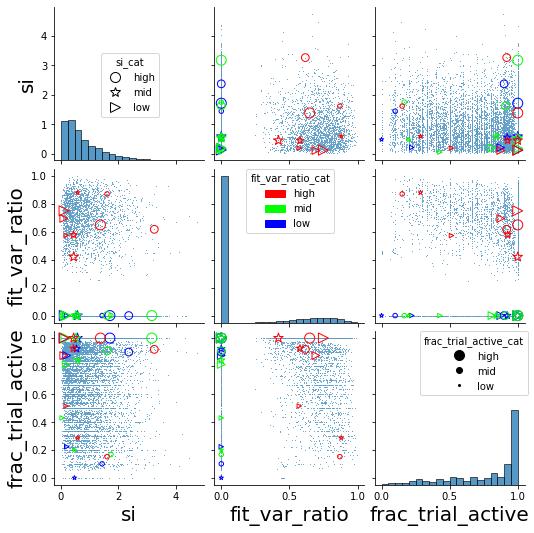

In [506]:
g = sns.pairplot(data=data_to_plot,plot_kws=dict(s=1.),diag_kws={'bins':20})
feat_cols_ = data_to_plot.columns
axs = g.axes
nrows,ncols = axs.shape
for r in range(nrows):
    for c in range(ncols):
        if r!=c:
            x = feat_cols_[c]
            y = feat_cols_[r]
            ax = axs[r,c]
            for ii,(_,row) in enumerate(data_selected_with_feat_cat_l.iterrows()):
#                 ax.scatter(row[x],row[y],color=c_l[ii],marker=marker_l[ii],s=s_l[ii])
                ax.scatter(row[x],row[y],color=c_l[ii],marker=marker_l[ii],s=s_l[ii],edgecolor=c_l[ii],facecolors='none')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D


# Define colors, markers and sizes
colors = colors_d.values()
markers = markers_d.values()
sizes = sizes_d.values()

# Create color legend
color_patches = [mpatches.Patch(color=color, label=label) for label,color in colors_d.items()]
color_legend = axs[1,1].legend(handles=color_patches, title=color_col, bbox_to_anchor=(0.8, 1), loc='upper right', borderaxespad=0.)

# Create marker legend
marker_lines = [Line2D([0], [0], color='k', marker=marker, linewidth=0, markersize=10,markerfacecolor='none', label=label) for label,marker  in markers_d.items()]
marker_legend = axs[0,0].legend(handles=marker_lines, title=marker_col, bbox_to_anchor=(0.7, 0.7), loc='upper right', borderaxespad=0.)

# Create size legend
size_lines = [Line2D([0], [0], color='k', marker='o', linewidth=0, markersize=size/10, label=label) for label,size in sizes_d.items()]
size_legend = axs[2,2].legend(handles=size_lines, title=size_col, bbox_to_anchor=(0.3, 1.), loc='upper left', borderaxespad=0.)

# # Add the legends to the plot
# ax.add_artist(color_legend)
# ax.add_artist(marker_legend)
plt.show()

# fn_full =os.path.join(figdir_supp_pen,'pairplot.png')
fn_full =os.path.join(figdir_supp_pen,'pairplot_all.png')
g.figure.savefig(fn_full,bbox_inches='tight')

            

/tmp/ipykernel_59910/2805592787.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/2805592787.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/2805592787.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/2805592787.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_59910/2805592787.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipyke

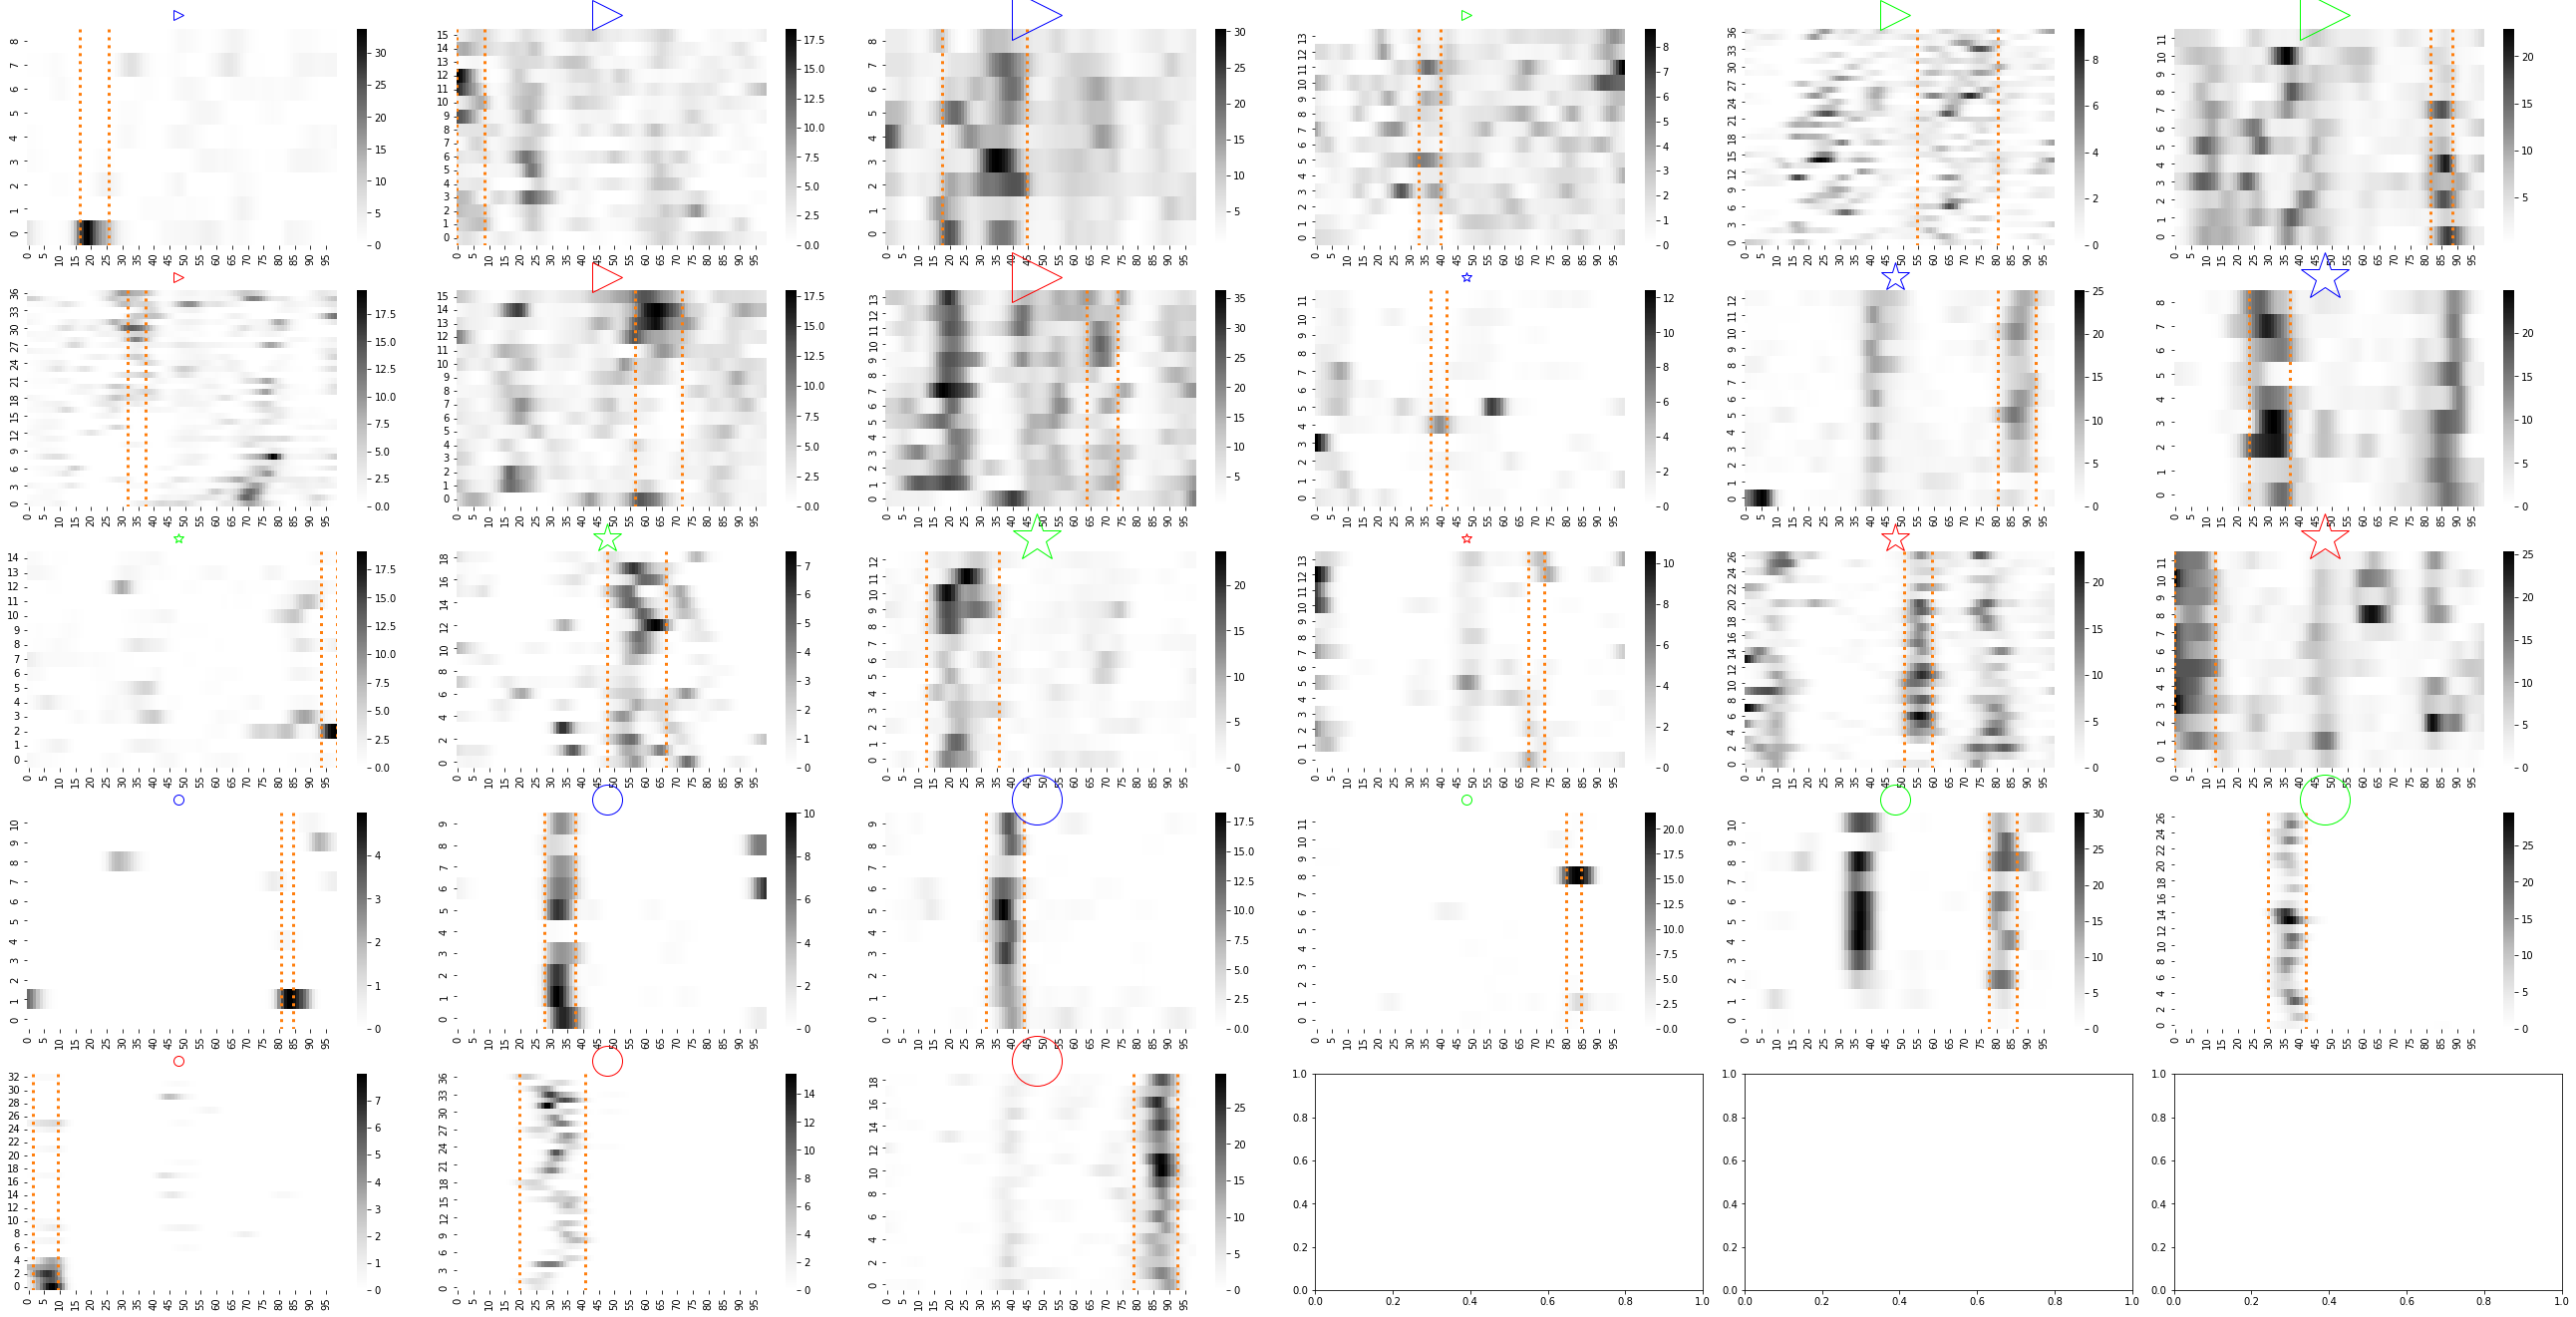

In [507]:
nplots = data_selected_with_feat_cat_l.shape[0]
# assert nplots==8
# if nplots>0:
fig,axs=ph.subplots_wrapper(nplots,squeeze=False)
# fig,axs = plt.subplots(2,4,figsize=(4*6,2*4+3))

for ii,(_,row) in enumerate(data_selected_with_feat_cat_l.iterrows()):
    ax = axs.ravel()[ii]
    ani,sess,ti,tt,uid,field_id=row['ind']
    if tt=='both':
        tt_rm=0
    else:
        tt_rm=tt
    field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]

    fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
    ax=axs.ravel()[ii]
    fig,ax=ph.ratemap_one_raw(fr_map_trial_one,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})
    ax.invert_yaxis()
#     ax.set_title(f'{tt}, {uid}, {field_id}')
    
    c=colors_d[row[color_col]]
    m = markers_d[row[marker_col]]
    s= sizes_d[row[size_col]]
    title_element = [Line2D([0], [0], color=c, marker=m, linewidth=0, markersize=s,markerfacecolor='none')]
    marker_legend = ax.legend(handles=title_element, title=None, markerscale=0.5,bbox_to_anchor=(0.5, 1.1), frameon=False,loc='upper center', borderaxespad=0.)

    
plt.tight_layout()
plt.subplots_adjust(top=0.9) 
#     fn_full = os.path.join(figdir_supp,f'{}_examples.png'
#     fig.savefig(fn_full,bbox_inches='tight')
#     plt.close(fig)

# fn_full =os.path.join(figdir_supp_pen,'examples.png')
fn_full =os.path.join(figdir_supp_pen,'examples_all.png')
fig.savefig(fn_full,bbox_inches='tight')


# hand define some categories

In [70]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler,QuantileTransformer
# feat_cols = ['frac_trial_active','fr_cv_beh','fit_var_ratio','resid2_mean_norm','sparsity']
# feat_cols = ['si','fit_var_ratio','frac_trial_active']
feat_cols = ['si','fit_var_ratio','fit_var_ratio_pen','fr_cv_beh']

# sess = 'e15_13f1_220117'
# per_field_metrics_all_sub = per_field_metrics_all.loc[(slice(None),sess),:]
per_field_metrics_all_sub = per_field_metrics_all.loc[(slice(None),slice(None),[0])]
data=per_field_metrics_all_sub.loc[:,feat_cols]
data_norm=StandardScaler().fit_transform(data)
# data_norm = QuantileTransformer().fit_transform(data)
data_norm = pd.DataFrame(data_norm,index=data.index,columns=data.columns)


In [133]:
# # ma=(data_norm['si']>0.8)&(data_norm['frac_trial_active']<0.2)
# # ma=(data['si']>1)&(data['fr_cv_beh']>1.)
# nsample = 20
# toplot_key_sample = {}

# ma=(data_norm['si']>0)&(data_norm['fr_cv_beh']>1.)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fit_var_ratio')
# toplot_key_sample['noisy_bubble'] = toplot_data_sample

# ma=(data_norm['si']>0.)&(data_norm['fr_cv_beh']<0.)&(data['fit_var_ratio']==0.)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# # toplot_data_sample=toplot_data_sample.sort_values('fr_cv_beh')
# toplot_data_sample=toplot_data_sample.sort_values('si')
# toplot_key_sample['stable_field'] = toplot_data_sample

# ma=(data_norm['si']>0)&(data_norm['fr_cv_beh']<-0.5)&(data['fit_var_ratio']>0.7)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fit_var_ratio')
# toplot_key_sample['stable_field_rate_switch'] = toplot_data_sample

# ma=(data_norm['si']>0)&(data_norm['fr_cv_beh']>0.5)&(data_norm['fr_cv_beh']<1.5)&(data['fit_var_ratio']>0.7)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fit_var_ratio')
# toplot_key_sample['clean_switch'] = toplot_data_sample

# # ma=(data_norm['si']<0)&(data_norm['fr_cv_beh']>0.5)&(data_norm['fr_cv_beh']<1.5)&(data['fit_var_ratio']>0.7)
# ma=(data_norm['si']<-0.5) & (data['fit_var_ratio']>0.7)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fit_var_ratio')
# toplot_key_sample['switch_in_noisy_fields'] = toplot_data_sample


# ma=(data_norm['si']<-0.5) & (data['fit_var_ratio_pen']>0.7)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fit_var_ratio')
# toplot_key_sample['switch_in_noisy_fields_pen'] = toplot_data_sample


# ma=(data_norm['si']<-0.5) & (data['fit_var_ratio']==0) & (data_norm['fr_cv_beh']<-0.5)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('si')
# # toplot_key_sample['switch_in_noisy_fields'] = toplot_data_sample

# # ma=(data_norm['si']<-0.5) & (data['fit_var_ratio']==0) & (data_norm['fr_cv_beh']>1)
# # toplot_data_sample=data_norm.loc[ma].sample(nsample)
# # toplot_data_sample=toplot_data_sample.sort_values('si')

# ma=(data['fit_var_ratio_pen']==0.) & (data_norm['fr_cv_beh']<-0.5)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('si')


In [145]:
# nsample = 25
# toplot_key_sample = {}

# ma=(data_norm['si']>0)&(data['fit_var_ratio']>0.7)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fr_cv_beh')
# toplot_key_sample['high_si_with_switch'] = toplot_data_sample

# ma=(data_norm['si']<-0.5)&(data['fit_var_ratio']>0.7)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fr_cv_beh')
# toplot_key_sample['low_si_with_switch'] = toplot_data_sample

# ma=(data_norm['si']>0)&(data['fit_var_ratio']==0.)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fr_cv_beh')
# toplot_key_sample['high_si_no_switch'] = toplot_data_sample

# ma=(data_norm['si']<-0.5)&(data['fit_var_ratio']==0)
# toplot_data_sample=data_norm.loc[ma].sample(nsample)
# toplot_data_sample=toplot_data_sample.sort_values('fr_cv_beh')
# toplot_key_sample['low_si_no_switch'] = toplot_data_sample

In [190]:
nsample = 25
toplot_key_sample = {}

ma=(data_norm['fr_cv_beh']>1.5)&(data['fit_var_ratio']>0.7)
toplot_data_sample=data_norm.loc[ma].sample(nsample)
toplot_data_sample=toplot_data_sample.sort_values('si')
toplot_key_sample['high_cv_with_switch'] = toplot_data_sample


ma=(data_norm['fr_cv_beh']<1.5)&(data_norm['fr_cv_beh']>0.5)&(data['fit_var_ratio']>0.7)
toplot_data_sample=data_norm.loc[ma].sample(nsample)
toplot_data_sample=toplot_data_sample.sort_values('si')
toplot_key_sample['mid_cv_with_switch'] = toplot_data_sample


ma=(data_norm['fr_cv_beh']<0)&(data['fit_var_ratio']>0.7)
toplot_data_sample=data_norm.loc[ma].sample(nsample)
toplot_data_sample=toplot_data_sample.sort_values('si')
toplot_key_sample['low_cv_with_switch'] = toplot_data_sample

ma=(data_norm['fr_cv_beh']>1.5)&(data['fit_var_ratio']==0)
toplot_data_sample=data_norm.loc[ma].sample(nsample)
toplot_data_sample=toplot_data_sample.sort_values('si')
toplot_key_sample['high_cv_no_switch'] = toplot_data_sample


ma=(data_norm['fr_cv_beh']<1.5)&(data_norm['fr_cv_beh']>0.5)&(data['fit_var_ratio']==0)
toplot_data_sample=data_norm.loc[ma].sample(nsample)
toplot_data_sample=toplot_data_sample.sort_values('si')
toplot_key_sample['mid_cv_no_switch'] = toplot_data_sample


ma=(data_norm['fr_cv_beh']<0)&(data['fit_var_ratio']==0)
toplot_data_sample=data_norm.loc[ma].sample(nsample)
toplot_data_sample=toplot_data_sample.sort_values('si')
toplot_key_sample['low_cv_no_switch'] = toplot_data_sample

<Axes: >

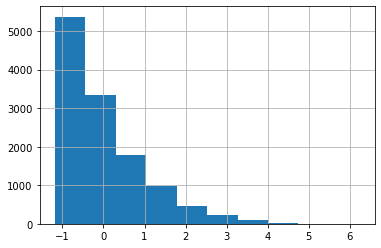

In [109]:
data_norm['si'].hist()

In [191]:
# key = 'high_si_no_switch'#'low_si_no_switch'
for key in toplot_key_sample.keys():
    toplot_data_sample = toplot_key_sample[key]
    toplot_inds=toplot_data_sample.index
    nplots=len(toplot_inds)

    fig,axs=ph.subplots_wrapper(nplots,squeeze=False)

    for ii,jj in enumerate(toplot_inds):
        ani,sess,ti,tt,uid,field_id=jj
        if tt=='both':
            tt_rm=0
        else:
            tt_rm=tt
        field_bound = all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_id),('start','end')]

        fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
        ax=axs.ravel()[ii]
        ph.ratemap_one_raw(fr_map_trial_one,field_bound=field_bound,fig=fig,ax=ax,line_kws={},title=None,heatmap_kws={})
    #     ax.set_title(f'{tt}, {uid}, {field_id}')
        fit_var_ratio = data.loc[jj]['fit_var_ratio']
        fit_var_ratio_pen = data.loc[jj]['fit_var_ratio_pen']
        fr_cv_beh = data.loc[jj]['fr_cv_beh']
        si = data.loc[jj]['si']
        ax.set_title(f'shuffle test r2: {fit_var_ratio:.01f}\n penalty r2: {fit_var_ratio_pen:.01f}\n FR CV: {fr_cv_beh:.01f}\n si: {si:.01f}')
    plt.tight_layout()
    fn_full = os.path.join(figdir,f'{key}_examples.png')
    fig.savefig(fn_full,bbox_inches='tight')
    plt.close(fig)

/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/

/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/

/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/

/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/ipykernel_1096342/707148467.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_map_trial_one=fr_map_trial_df_all.loc[(ani,sess,ti,tt_rm,uid),:].dropna(axis=1).T
/tmp/

# across task metric comparison

In [148]:
subdb_two_tasks = subdb.loc[[x.startswith('[') for x in subdb['behavior']]]
sess_two_tasks = subdb_two_tasks['sess_name']

In [149]:
sess_two_tasks

animal_name   
e15_13f1     1    e15_13f1_220118
             2    e15_13f1_220119
             3    e15_13f1_220120
e13_26m1     1    e13_26m1_211019
             2    e13_26m1_211116
e16_3m2      3     e16_3m2_211213
             2     e16_3m2_211212
e13_26m1     3    e13_26m1_211119
Name: sess_name, dtype: object

In [152]:
per_field_metrics_all_two_task=per_field_metrics_all.loc[(slice(None),sess_two_tasks),:]

In [159]:
per_neuorn_metrics_by_mean = per_field_metrics_all_two_task.groupby(level=(0,1,2,4)).mean()

In [167]:
toplot

0         1
e13_26m1 e13_26m1_211019 1    0.375000  0.311688
                         11   0.987500  1.000000
                         18   0.850000  0.136905
                         27   1.000000  1.000000
                         35   0.850591  0.809524
...                                ...       ...
e16_3m2  e16_3m2_211213  203  0.100000  1.000000
                         204  0.970588  0.500000
                         205  0.617647  0.437500
                         206  0.912941  0.846154
                         207  0.432353  0.502404

[951 rows x 2 columns]

In [182]:
np.any(np.isclose(toplot,0),axis=1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

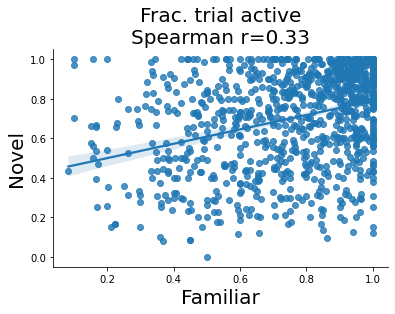

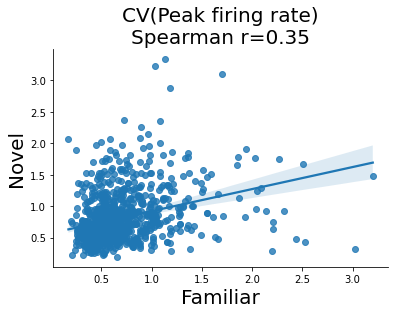

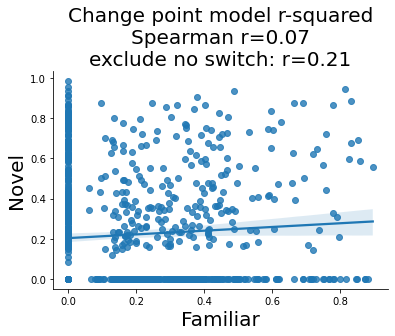

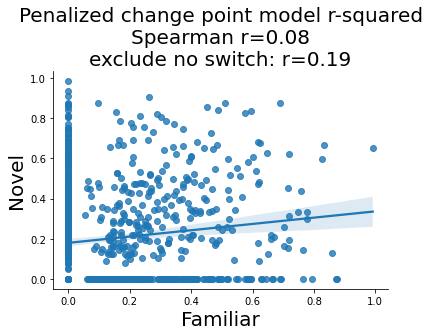

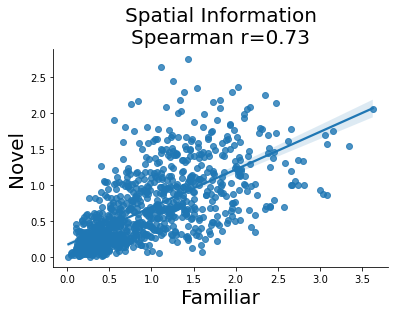

In [187]:
title_map = {'frac_trial_active':'Frac. trial active',
             'fr_cv_beh':'CV(Peak firing rate)',
             'fit_var_ratio':'Change point model r-squared',
             'fit_var_ratio_pen':'Penalized change point model r-squared',
             'si':'Spatial Information'}
for feat in ['frac_trial_active','fr_cv_beh','fit_var_ratio','fit_var_ratio_pen','si']:
    fig,ax=plt.subplots()

    toplot=per_neuorn_metrics_by_mean[feat].unstack(level=2).dropna(axis=0)
    r,pval=scipy.stats.spearmanr(toplot.iloc[:,0],toplot.iloc[:,1])
    feat_title = title_map[feat]
    title=feat_title+f'\nSpearman r={r:.02f}'
    if 'fit_var_ratio' in feat:
        toplot_no_nosw=toplot.loc[~np.any(np.isclose(toplot,0),axis=1)]
        r_exclude_nosw,pval=scipy.stats.spearmanr(toplot_no_nosw.iloc[:,0],toplot_no_nosw.iloc[:,1])
        title=title+f'\nexclude no switch: r={r_exclude_nosw:.02f}'
    toplot=toplot.rename({0:'Familiar',1:'Novel'},axis=1)
    ax=sns.regplot(data=toplot,x='Familiar',y='Novel',ax=ax)
    sns.despine()
    ax.set_title(title)
    
    for fmt in ['png','svg']:
        fn_full = os.path.join(figdir,f'novel_vs_fam_{feat}.{fmt}')
        fig.savefig(fn_full,bbox_inches='tight')

In [244]:
feat_cols

['lap_correlation', 'fit_var_ratio', 'frac_trial_active']

In [243]:
feat_l

['lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'lap_correlation',
 'fit_var_ratio',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'lap_correlation',
 'fit_var_ratio',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_correlation',
 'fit_var_ratio',
 'frac_trial_active',
 'lap_co

In [ ]:
selected

In [239]:
feat

'frac_trial_active'

In [237]:
k

'lap_correlation_high; fit_var_ratio_high; frac_trial_active_high'

In [235]:
ma.loc[ma].index[0]

('e15_13f1', 'e15_13f1_220117', 0, 0.0, 108, 1)

In [223]:
reload(ph)
x = 'fr_cv_beh'#'sparsity'
colors = QuantileTransformer().fit_transform(per_field_metrics_all_sub[[x]].values.astype(float))[:,0]
c=ph.prep_color(colors)
c=None

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (682). n_quantiles is set to n_samples.
  warnings.warn(


<IPython.core.display.Javascript object>


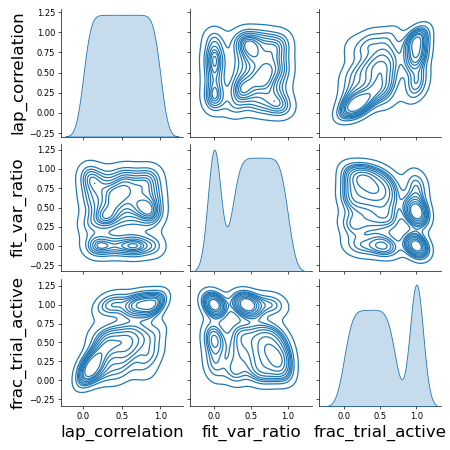

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [222]:
sns.pairplot(data=data_norm,kind='kde')
# sns.pairplot(data=data,kind='hist')

<IPython.core.display.Javascript object>


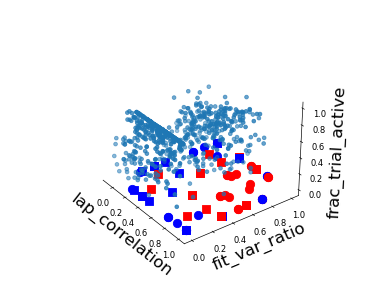

[Text(0.5, 0, 'lap_correlation'),
 Text(0.5, 0.5, 'fit_var_ratio'),
 Text(0.5, 0, 'frac_trial_active')]

In [225]:
%matplotlib notebook
fig=plt.figure()
ax=fig.add_subplot(projection='3d')

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_pane_color((1,1,1))
    axis._axinfo["grid"]['color'] =  (1,1,1,0)
toplot=data#data_norm
ax.scatter(toplot.iloc[:,0],toplot.iloc[:,1],toplot.iloc[:,2],c=c)
ax.set(xlabel=toplot.columns[0],ylabel=toplot.columns[1],zlabel=toplot.columns[2])


<IPython.core.display.Javascript object>


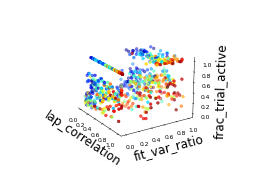

[Text(0.5, 0, 'lap_correlation'),
 Text(0.5, 0.5, 'fit_var_ratio'),
 Text(0.5, 0, 'frac_trial_active')]

In [209]:
%matplotlib notebook
fig=plt.figure()
ax=fig.add_subplot(projection='3d')

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.set_pane_color((1,1,1))
    axis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.scatter(data_norm.iloc[:,0],data_norm.iloc[:,1],data_norm.iloc[:,2],c=c)
ax.set(xlabel=data_norm.columns[0],ylabel=data_norm.columns[1],zlabel=data_norm.columns[2])


In [89]:
# gpb = fr_map_all.groupby(level=(0,1,2,3),sort=False)
# spa_all = []
# for k,val in gpb:
#     val = val.dropna(axis=1)
#     spa = np.average(val**2 / (val.mean(axis=1)**2).values[:,None],weights=occu_map_all.loc[k],axis=1)
#     spa=pd.Series(spa,index=val.index)
#     spa_all.append(spa)
# spa_all = pd.concat(spa_all,axis=0)
    
# #     val

/tmp/ipykernel_59910/3067315274.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  spa = np.average(val**2 / (val.mean(axis=1)**2).values[:,None],weights=occu_map_all.loc[k],axis=1)
